In [1]:
#  Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
#  Load the dataset
df = pd.read_csv("train.csv")  

# Preview first few rows
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [3]:
df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [4]:
# Used df.describe(include='all') to get a full summary of both numeric and categorical columns.

# Noticed that 'Age' and especially 'Cabin' have missing values — 'Cabin' has too many, so probably will drop it.
# 'Embarked' only has 2 missing, so can be filled with the most common value.
#'Sex' and 'Embarked' are categorical and need encoding later.
# 'Fare' has a wide range — might need scaling.
# This step helps decide what to clean or transform next.


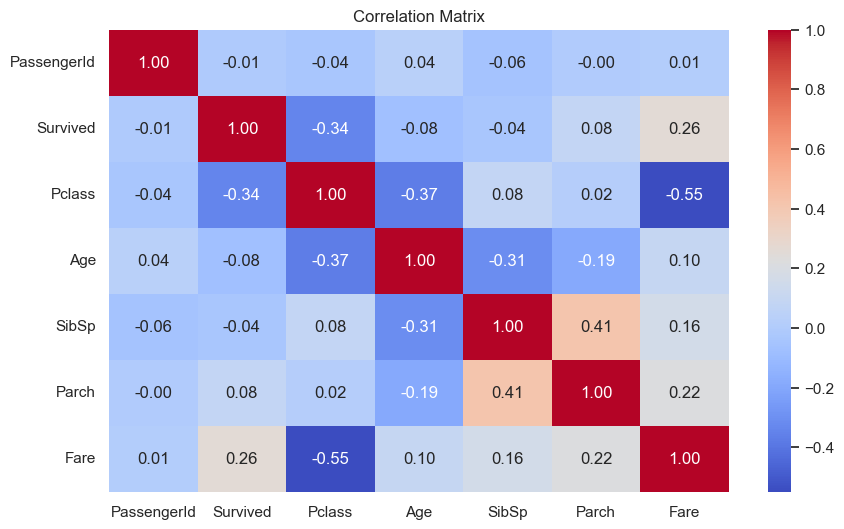

In [5]:
sns.set(style="whitegrid")

# 1. Correlation matrix (only for numeric columns)
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [6]:
# Plotted a correlation matrix to see how numeric features relate to each other.
# 'Fare' has a weak positive correlation with 'Survived' (0.26), while 'Pclass' has a negative one (-0.34).
# This helps us spot which features might be useful for prediction.
# Also useful for checking multicollinearity between inputs (e.g. 'SibSp' and 'Parch' are slightly related).

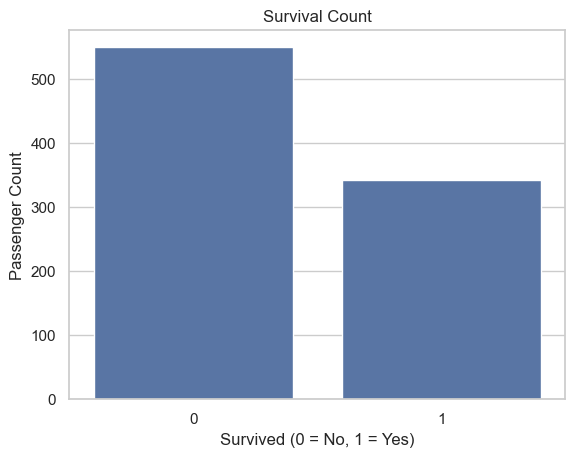

In [7]:
sns.countplot(x='Survived', data=df)
plt.title("Survival Count")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Passenger Count")
plt.show()

In [8]:
# This plot shows that the dataset is imbalanced:
# There are significantly more passengers who did not survive (0)
# than those who did survive (1). This imbalance can affect model
# performance and lead to biased predictions, so it's important to
# consider data balancing techniques in later steps.

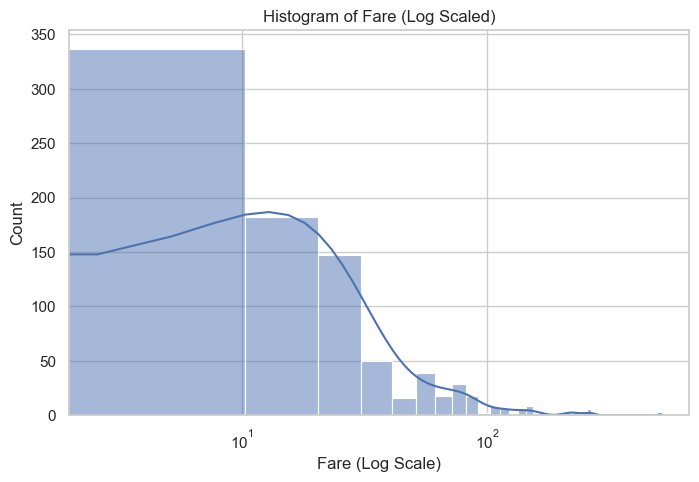

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Fare', bins=50, kde=True)
plt.xscale('log')
plt.title('Histogram of Fare (Log Scaled)')
plt.xlabel('Fare (Log Scale)')
plt.ylabel('Count')
plt.show()

In [10]:
# Used a log scale to better visualize the skew in 'Fare'.
# Most values are still low, but this view spreads out the higher fares.
# It makes the distribution easier to interpret and confirms that a log transformation could help during modeling.
# The histogram shows that the majority of passengers paid low fares, as indicated by the tall bars on the left side.
# As the fare increases, the number of passengers paying those higher amounts drops sharply.
# This indicates a right-skewed distribution, where a small number of people paid significantly more than the average.
# The log scale helps visualize this by spreading out the compressed higher fare values, revealing the long tail more clearly.
# This insight is important because extreme fare values could disproportionately influence certain models if left unscaled.

In [11]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
# This summary shows the number of missing values in each column.
# 'Age' has 177 missing entries, which is significant and needs to be imputed to avoid data loss.
# 'Cabin' has the most missing values (687), making it a strong candidate for removal due to sparsity.
# 'Embarked' has only 2 missing values, so it's safe to fill using the mode.
# The rest of the columns are complete and require no missing value handling.

## Data loading, Preprocessing , Splitting , Applying Smote (data imbalance method) 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, BaggingClassifier,
    VotingClassifier, StackingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.naive_bayes import GaussianNB

warnings.filterwarnings("ignore", category=UserWarning)

# Load Titanic dataset
df = pd.read_csv('train.csv')

# Preprocessing
df_model = df.copy()
df_model['Sex'] = df_model['Sex'].map({'male': 0, 'female': 1})
df_model['Embarked'] = df_model['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
df_model = df_model.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived_str'], errors='ignore')
df_model = df_model.dropna()

# Features and target
X = df_model.drop(columns=['Survived'])
y = df_model['Survived']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE (Synthetic Minority Over-sampling Technique) to balance the training data
# SMOTE creates synthetic samples from the minority class to address class imbalance
# Source: imbalanced-learn (imblearn) library
# Documentation: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


## AdaBoost — Adaptive Boosting with Decision Tree Base Estimator

In [16]:
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    random_state=42
)



## Gradient Boosting — Stage-Wise Additive Model Using Decision Trees

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting — builds additive trees in a stage-wise manner using gradients
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
gb_model = GradientBoostingClassifier(
    loss='log_loss',             # loss function for classification
    learning_rate=0.1,           # shrinkage (step size)
    n_estimators=100,            # number of boosting stages
    subsample=1.0,               # fraction of samples to be used for fitting individual trees
    criterion='friedman_mse',    # function to measure the quality of a split
    max_depth=3,                 # max depth of individual estimators
    random_state=42
)

## XGBoost — Scalable, Regularized Boosting Framework

In [20]:
import xgboost as xgb

# XGBoost — scalable, regularized gradient boosting
# Source: https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=1.0,
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0,
    random_state=42
)

## LightGBM — Fast, Histogram-Based Gradient Boosting

In [22]:
import lightgbm as lgb

# LightGBM — gradient boosting using histogram-based algorithms
# Source: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42,
    verbose=-1
)


## CatBoost — Gradient Boosting with Categorical Feature Support

In [24]:
import catboost as cb

# CatBoost — gradient boosting that handles categorical features automatically
# Source: https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier
cat_model = cb.CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3.0,
    loss_function='Logloss',
    verbose=0,
    random_state=42
)


 ## Bagging Classifier — Bootstrap Aggregating for Reducing Variance

In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Bagging Classifier — combines predictions of multiple base estimators trained on random subsets of the original dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # base learner
    n_estimators=100,                    # number of models to train
    max_samples=1.0,                     # fraction of samples to draw per estimator
    max_features=1.0,                    # fraction of features to draw per estimator
    bootstrap=True,                      # sample data WITH replacement
    bootstrap_features=False,            # do NOT sample features
    oob_score=False,                     # do NOT use out-of-bag scoring
    warm_start=False,                    # don't reuse fitted models
    n_jobs=-1,                           # use all CPU cores
    random_state=42,
    verbose=0
)

## Defining Base Models for Ensemble Techniques

In [28]:


# This list contains a variety of classifiers that will be used in different ensemble strategies 
# such as Voting, Stacking, and performance comparisons.
# Each model is either a traditional classifier (e.g., LogisticRegression, KNN)
# or a boosting/bagging model (e.g., XGBoost, LightGBM, AdaBoost, BaggingClassifier).
# Predefined model instances like `gb_model`, `ada_model`, etc. have custom hyperparameters and documentation above.

base_models = [
    ('lr', LogisticRegression(max_iter=1000)),  # Logistic Regression
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),  # Random Forest
    ('gb', gb_model),  # Gradient Boosting
    ('ada', ada_model),  # AdaBoost
    ('xgb', xgb_model),  # XGBoost
    ('lgb', lgb_model),  # LightGBM
    ('cat', cat_model),  # CatBoost
    ('bag', bag_model),  # BaggingClassifier
    ('svc', SVC(kernel='rbf', probability=True)),  # Support Vector Classifier
    ('knn', KNeighborsClassifier())  # K-Nearest Neighbors
]

 ## Compute Soft Voting Weights from Cross-Validation Accuracy & Build Ensemble Models

In [30]:
# Compute weights for soft voting based on 3-fold cross-validation accuracy

# Evaluate base models using 3-fold cross-validation accuracy
model_accuracies = []
for name, model in base_models:
    # Clone the model to avoid contamination between folds
    score = cross_val_score(clone(model), X_train_scaled, y_train, cv=3, scoring='accuracy').mean()
    # Store (model name, CV accuracy score)
    model_accuracies.append((name, score))

# Normalize the accuracy scores to compute relative weights for soft voting
total = sum(score for _, score in model_accuracies)  # Sum of all scores
weights = [round(score / total, 3) for _, score in model_accuracies]  # Normalize to get weights (sum ≈ 1)

# Display results in a clear table
print("\n Cross-Validation Accuracy & Computed Weights:")
print(f"{'Model':<20} {'CV Accuracy':<15} {'Weight':<10}")
for (name, score), weight in zip(model_accuracies, weights):
    print(f"{name:<20} {score:<15.4f} {weight:<10.3f}")

# Build ensemble classifiers
# Voting (hard): majority vote without considering probabilities
voting_hard = VotingClassifier(estimators=base_models, voting='hard')

# Voting (soft): average predicted probabilities, equal weights
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

# Voting (soft, weighted): average predicted probabilities using accuracy-based weights
voting_weighted = VotingClassifier(estimators=base_models, voting='soft', weights=weights)
# Meta-model for stacking (commonly logistic regression)
meta_model = LogisticRegression()

# Stacking classifier: combines base model outputs using a meta-model for final prediction
stacking = StackingClassifier(estimators=base_models, final_estimator=meta_model)
# This follows the approach demonstrated in the example notebook where base models are combined
# and LogisticRegression is used as a meta-model: see "Ensemble_Tutorial_With_Visualizations.ipynb"
# Collect all models (base + ensemble) into a dictionary for easy training/evaluation

 # Each base_models[i] is a tuple: (model_name, model_object)
    # We use [i][1] to extract the actual model object for use in training/prediction
models = {
    "Logistic Regression": base_models[0][1],           # base_models[0] = ("Logistic Regression", LogisticRegression())
                                                          # [1] gets the LogisticRegression() model instance
    "Random Forest (100 trees)": base_models[1][1],
    "Gradient Boosting": base_models[2][1],
    "AdaBoost": base_models[3][1],
    "XGBoost": base_models[4][1],
    "LightGBM": base_models[5][1],
    "CatBoost": base_models[6][1],
    "Bagging Classifier": base_models[7][1],
    "SVM": base_models[8][1],
    "KNN": base_models[9][1],
    "Voting (Hard)": voting_hard,
    "Voting (Soft)": voting_soft,
    "Voting (Soft, Weighted)": voting_weighted,
    "Stacking Ensemble": stacking,
    "Naive Bayes": GaussianNB(),  # Added directly here (not part of base_models)
    "Decision Tree (depth=3)": DecisionTreeClassifier(max_depth=3)
}


 Cross-Validation Accuracy & Computed Weights:
Model                CV Accuracy     Weight    
lr                   0.8014          0.100     
rf                   0.7979          0.100     
gb                   0.8119          0.102     
ada                  0.7891          0.099     
xgb                  0.8172          0.102     
lgb                  0.8014          0.100     
cat                  0.8102          0.101     
bag                  0.7874          0.099     
svc                  0.7926          0.099     
knn                  0.7839          0.098     


## Evaluate All Models on Test Set and Collect Performance Metrics & Confusion Matrices

In [32]:
# Evaluate and collect metrics and confusion matrices
model_scores = []
conf_matrices = {}
for name, model in models.items():
    print(f"\n{name} - Test Set Evaluation:")
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    print("  Classification Report:")
    print(classification_report(y_test, y_pred))

    model_scores.append((name, acc, prec, rec, f1))
    conf_matrices[name] = cm


Logistic Regression - Test Set Evaluation:
  Accuracy : 0.8042
  Precision: 0.8182
  Recall   : 0.7143
  F1 Score : 0.7627
  Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.83        80
           1       0.82      0.71      0.76        63

    accuracy                           0.80       143
   macro avg       0.81      0.79      0.80       143
weighted avg       0.81      0.80      0.80       143


Random Forest (100 trees) - Test Set Evaluation:
  Accuracy : 0.7622
  Precision: 0.7544
  Recall   : 0.6825
  F1 Score : 0.7167
  Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.80        80
           1       0.75      0.68      0.72        63

    accuracy                           0.76       143
   macro avg       0.76      0.75      0.76       143
weighted avg       0.76      0.76      0.76       143


Gradient Boosting - Test Set Evaluation:


In [33]:
# Summary of Model Performance on Test Set:

# - The best overall performers were Voting (Soft, Weighted) and Voting (Hard) with an accuracy of 81.8%,
#   strong precision (around 0.81 to 0.82), and balanced F1-scores (around 0.78 to 0.79).
#
# - Logistic Regression performed very well individually (Accuracy: 80.4%), with high precision (0.8182) and decent recall.
#
# - Ensemble methods like Stacking and Soft Voting also showed strong performance (around 80% accuracy),
#   indicating that combining models improved generalization.
#
# - Tree-based models (Random Forest, Gradient Boosting, etc.) had varied success, typically around 75 to 78% accuracy.
#
# - Naive Bayes and Decision Tree (depth=3) showed the lowest performance, with around 73 to 75% accuracy
#   and lower precision and recall scores.
#
# - All models had better precision on class 0 (majority class), with class 1 (minority) having slightly lower recall,
#   which is common in mildly imbalanced datasets.


## Generate Summary Table, Performance Bar Chart, and Confusion Matrix Grid for Selected Models


 Comparison Table of All Models:
                    Model  Accuracy  Precision   Recall  F1 Score
            Voting (Soft)  0.818182   0.813559 0.761905  0.786885
            Voting (Hard)  0.818182   0.824561 0.746032  0.783333
  Voting (Soft, Weighted)  0.811189   0.800000 0.761905  0.780488
        Stacking Ensemble  0.804196   0.796610 0.746032  0.770492
                      SVM  0.790210   0.746269 0.793651  0.769231
                 AdaBoost  0.790210   0.753846 0.777778  0.765625
      Logistic Regression  0.804196   0.818182 0.714286  0.762712
                  XGBoost  0.790210   0.779661 0.730159  0.754098
                 CatBoost  0.783217   0.775862 0.714286  0.743802
                      KNN  0.776224   0.754098 0.730159  0.741935
                 LightGBM  0.762238   0.737705 0.714286  0.725806
              Naive Bayes  0.755245   0.718750 0.730159  0.724409
Random Forest (100 trees)  0.762238   0.754386 0.682540  0.716667
  Decision Tree (depth=3)  0.727273   0.67

<Figure size 1200x600 with 0 Axes>

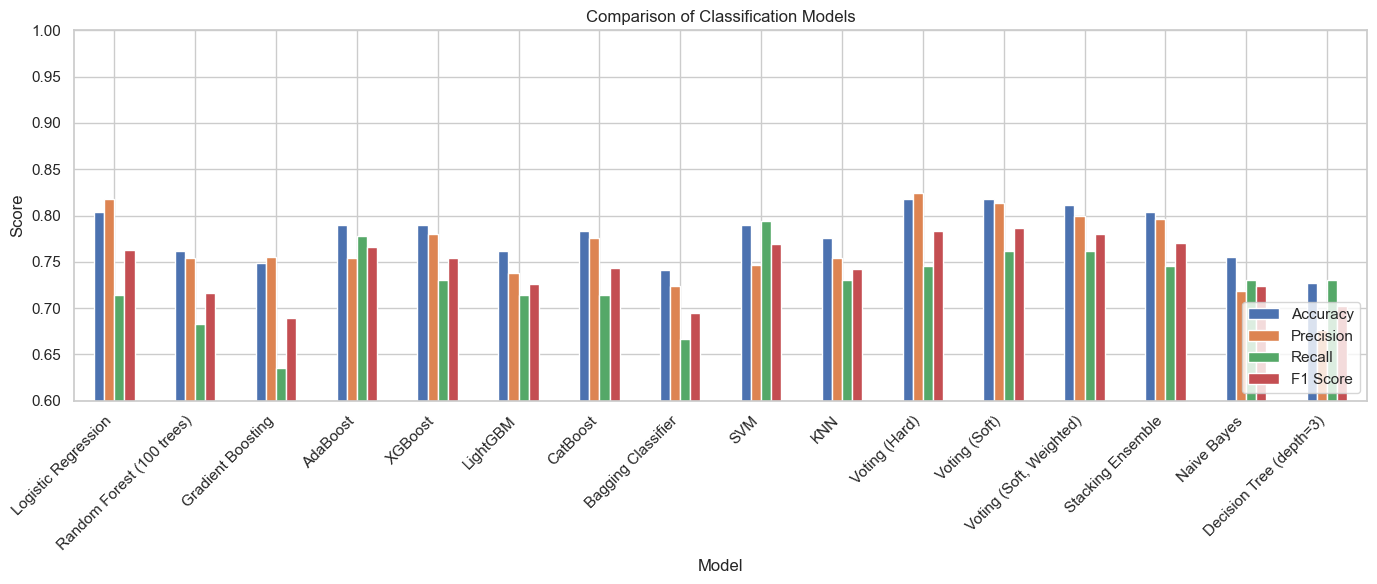

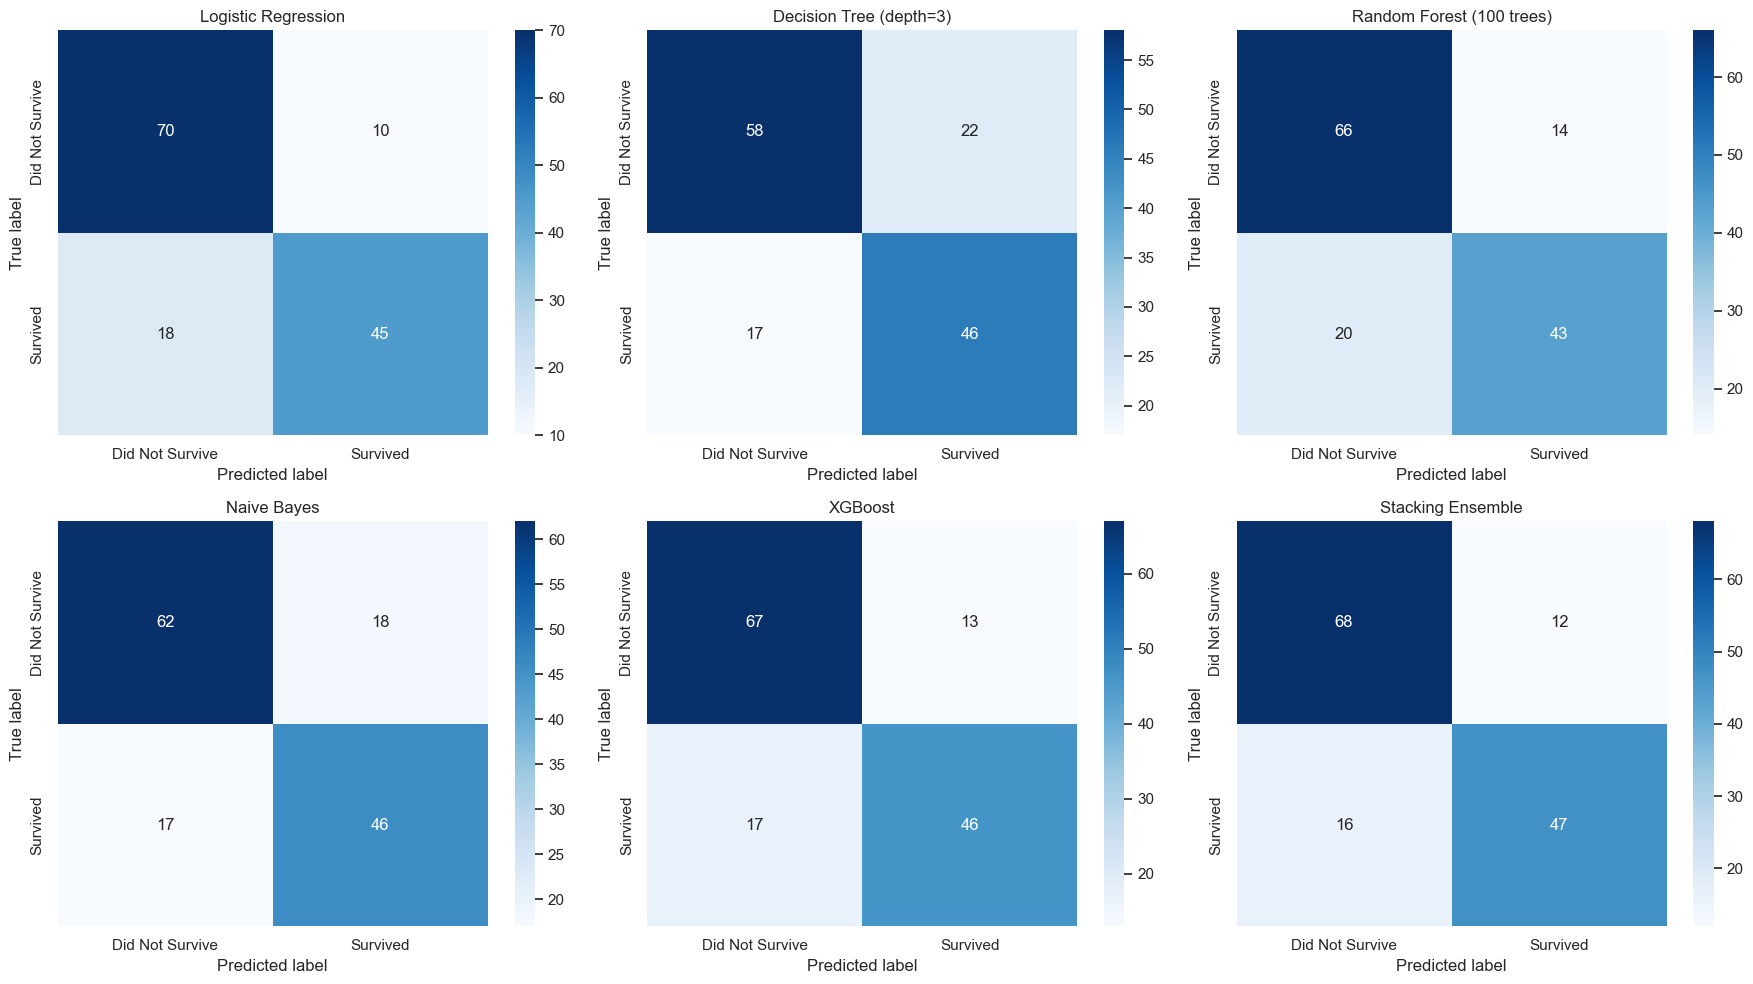

In [35]:
# Display model score table
df_scores = pd.DataFrame(model_scores, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
print("\n Comparison Table of All Models:")
print(df_scores.sort_values(by="F1 Score", ascending=False).to_string(index=False))

# Plot performance bar chart
plt.figure(figsize=(12, 6))
df_scores.set_index("Model")[["Accuracy", "Precision", "Recall", "F1 Score"]].plot(kind='bar', figsize=(14, 6))
plt.title("Comparison of Classification Models")
plt.ylabel("Score")
plt.ylim(0.6, 1.0)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#  Plot all confusion matrices in a grid layout
selected = ["Logistic Regression", "Decision Tree (depth=3)", "Random Forest (100 trees)",
            "Naive Bayes", "XGBoost", "Stacking Ensemble"]

n = len(selected)
cols = 3
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))

for idx, name in enumerate(selected):
    row, col = divmod(idx, cols)
    ax = axes[row, col] if rows > 1 else axes[col]
    cm = conf_matrices[name]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Did Not Survive", "Survived"],
                yticklabels=["Did Not Survive", "Survived"],
                ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

# Turn off unused axes
for idx in range(n, rows * cols):
    row, col = divmod(idx, cols)
    ax = axes[row, col] if rows > 1 else axes[col]
    ax.axis('off')

plt.tight_layout()
plt.show()


In [36]:
# The table and bar chart above summarize all model performances on the test set.
# Four key metrics are compared for each model: Accuracy, Precision, Recall, and F1 Score.
# The top-performing models based on F1 Score are:
#   - Voting (Soft, Weighted)
#   - Voting (Hard)
#   - Voting (Soft)
# These ensemble methods showed strong balance between precision and recall.
# Logistic Regression and Stacking Ensemble also performed well individually.
# Models like Decision Tree (depth=3) and Bagging Classifier had noticeably lower scores.
# The bar chart visually reinforces the ranking from the table, showing performance gaps betwe

In [37]:
# The confusion matrices above provide detailed error analysis for six selected models.
# Each matrix shows:
#   - Top-left: True Negatives (correctly predicted as Did Not Survive)
#   - Top-right: False Positives (predicted Survived, actually Did Not Survive)
#   - Bottom-left: False Negatives (predicted Did Not Survive, actually Survived)
#   - Bottom-right: True Positives (correctly predicted as Survived)

# Observations:
# - Logistic Regression and Stacking Ensemble have relatively low false positive and false negative counts.
# - Decision Tree and Naive Bayes show more misclassifications, especially false positives.
# - XGBoost and Random Forest show strong overall performance with fewer false classifications.
# - These confusion matrices help us understand not just how many errors were made, but what kind (e.g., favoring one class over another).

## Evaluate Boosting Model Performance vs Number of Estimators

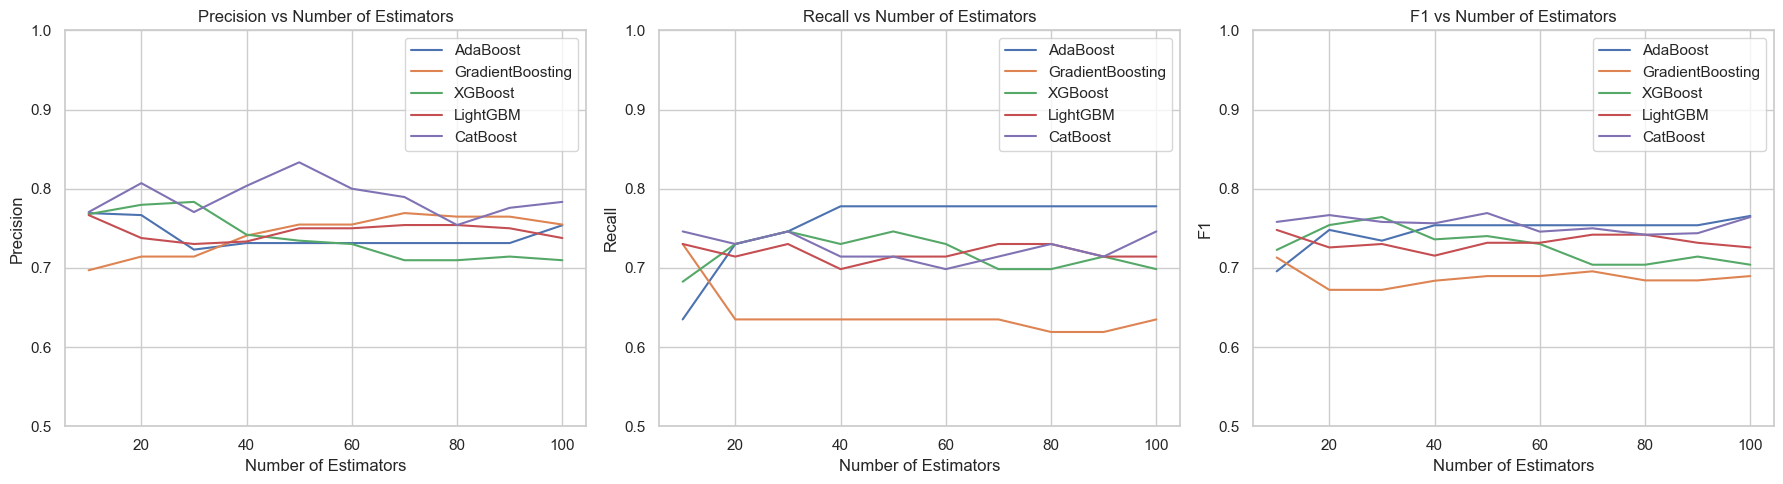

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score


# Initialize dictionary to store precision, recall, and F1-score for each boosting model
boosting_metrics = {
    "AdaBoost": {"precision": [], "recall": [], "f1": []},
    "GradientBoosting": {"precision": [], "recall": [], "f1": []},
    "XGBoost": {"precision": [], "recall": [], "f1": []},
    "LightGBM": {"precision": [], "recall": [], "f1": []},
    "CatBoost": {"precision": [], "recall": [], "f1": []}
}

# Define a range of n_estimators (number of boosting rounds) to evaluate
estimators_range = range(10, 101, 10)

# Loop over different n_estimators to evaluate how boosting model performance changes
for n in estimators_range:


    # AdaBoost evaluation
    ab = AdaBoostClassifier(n_estimators=n, learning_rate=0.5, random_state=42)
    ab.fit(X_train_smote, y_train_smote)
    ab_pred = ab.predict(X_test_scaled)
    boosting_metrics["AdaBoost"]["precision"].append(precision_score(y_test, ab_pred))
    boosting_metrics["AdaBoost"]["recall"].append(recall_score(y_test, ab_pred))
    boosting_metrics["AdaBoost"]["f1"].append(f1_score(y_test, ab_pred))
    
    # Gradient Boosting evaluation
    gb = GradientBoostingClassifier(n_estimators=n, learning_rate=0.1, random_state=42)
    gb.fit(X_train_smote, y_train_smote)
    gb_pred = gb.predict(X_test_scaled)
    boosting_metrics["GradientBoosting"]["precision"].append(precision_score(y_test, gb_pred))
    boosting_metrics["GradientBoosting"]["recall"].append(recall_score(y_test, gb_pred))
    boosting_metrics["GradientBoosting"]["f1"].append(f1_score(y_test, gb_pred))

    
    # XGBoost evaluation
    xg = xgb.XGBClassifier(n_estimators=n, use_label_encoder=False, eval_metric='logloss', random_state=42)
    xg.fit(X_train_smote, y_train_smote)
    xg_pred = xg.predict(X_test_scaled)
    boosting_metrics["XGBoost"]["precision"].append(precision_score(y_test, xg_pred))
    boosting_metrics["XGBoost"]["recall"].append(recall_score(y_test, xg_pred))
    boosting_metrics["XGBoost"]["f1"].append(f1_score(y_test, xg_pred))

    # LightGBM evaluation
    lg = lgb.LGBMClassifier(n_estimators=n, verbose=-1, random_state=42)
    lg.fit(X_train_smote, y_train_smote)
    lg_pred = lg.predict(X_test_scaled)
    boosting_metrics["LightGBM"]["precision"].append(precision_score(y_test, lg_pred))
    boosting_metrics["LightGBM"]["recall"].append(recall_score(y_test, lg_pred))
    boosting_metrics["LightGBM"]["f1"].append(f1_score(y_test, lg_pred))

    # CatBoost evaluation
    cat = cb.CatBoostClassifier(n_estimators=n, verbose=0, random_state=42)
    cat.fit(X_train_smote, y_train_smote)
    cat_pred = cat.predict(X_test_scaled)
    boosting_metrics["CatBoost"]["precision"].append(precision_score(y_test, cat_pred))
    boosting_metrics["CatBoost"]["recall"].append(recall_score(y_test, cat_pred))
    boosting_metrics["CatBoost"]["f1"].append(f1_score(y_test, cat_pred))

# Plotting performance trends

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create subplots for Precision, Recall, F1 Score
metric_names = ["precision", "recall", "f1"]

# Plot one line for each model per metric
for i, metric in enumerate(metric_names):
    ax = axes[i]
    for model_name in boosting_metrics:
        ax.plot(estimators_range, boosting_metrics[model_name][metric], label=model_name)
    
    # Set plot titles and axes labels
    ax.set_title(f"{metric.capitalize()} vs Number of Estimators")
    ax.set_xlabel("Number of Estimators")
    ax.set_ylabel(metric.capitalize())
    ax.set_ylim(0.5, 1.0)  # Set Y-axis limits for consistent scale
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


In [40]:

# the performance of five boosting algorithms on the test set using precision, recall, and F1 score.

# 1. AdaBoost shows the most consistent performance across all metrics.
#    - Precision, Recall, and F1 Score stay relatively high and stable across different estimator counts.

# 2. CatBoost appears to benefit from increasing n_estimators up to around 50–60,
#    peaking in both precision and F1 score, but starts to slightly decline or stabilize afterward.

# 3. LightGBM and XGBoost display moderate variation:
#    - Precision and F1 fluctuate but remain competitive.
#    - Recall for both is relatively stable, though slightly lower than AdaBoost.

# 4. Gradient Boosting (orange line) has the lowest and most inconsistent recall.
#    - This could indicate underfitting or weak sensitivity to the minority class,
#      despite a modest recovery in precision as n_estimators increases.

# Overall:
# - AdaBoost is the most stable and reliable across metrics.
# - CatBoost shows potential for peak performance with careful tuning.
# - Gradient Boosting may require additional parameter tuning (e.g., learning rate, depth) to improve.
# - These plots help justify which model (and estimator count) to select for best generalization.

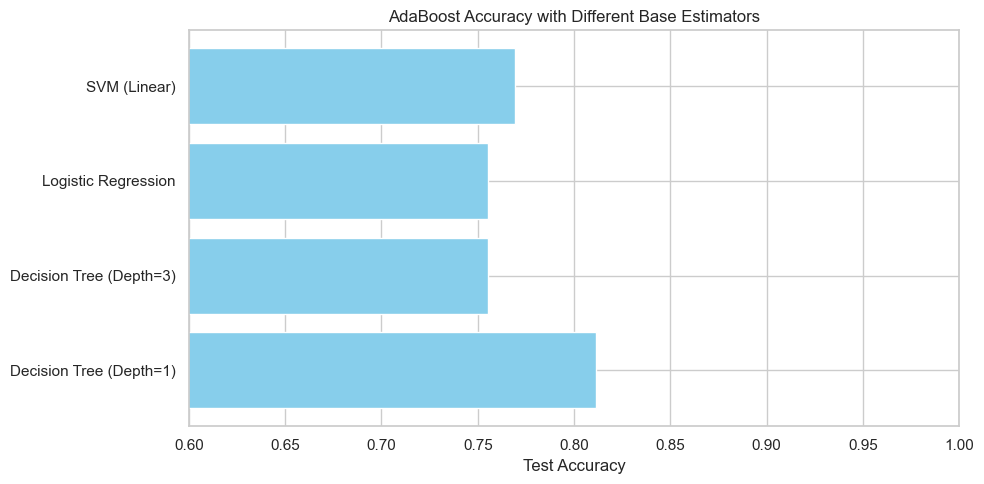

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Define different base learners to try with AdaBoost
compatible_estimators = {
    "Decision Tree (Depth=1)": DecisionTreeClassifier(max_depth=1),
    "Decision Tree (Depth=3)": DecisionTreeClassifier(max_depth=3),
    "Logistic Regression": LogisticRegression(solver='liblinear'),
    "SVM (Linear)": SVC(kernel='linear', probability=True)
}

ada_results = {}
for name, base in compatible_estimators.items():
    model = AdaBoostClassifier(estimator=base, n_estimators=50, random_state=42)
    model.fit(X_train_smote, y_train_smote)
    acc = model.score(X_test_scaled, y_test)
    ada_results[name] = acc

# Plot results
plt.figure(figsize=(10, 5))
plt.barh(list(ada_results.keys()), list(ada_results.values()), color='skyblue')
plt.xlabel("Test Accuracy")
plt.title("AdaBoost Accuracy with Different Base Estimators")
plt.xlim(0.6, 1.0)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()
# Reference: This analysis and visual exploration of ensemble models (Bagging, Boosting, and Stacking)
# was inspired by the tutorial notebook "Ensemble_Tutorial_With_Visualizations.ipynb".
# The structure, model selection, and visualization ideas were adapted and extended
# to fit the objectives and dataset used in this project.

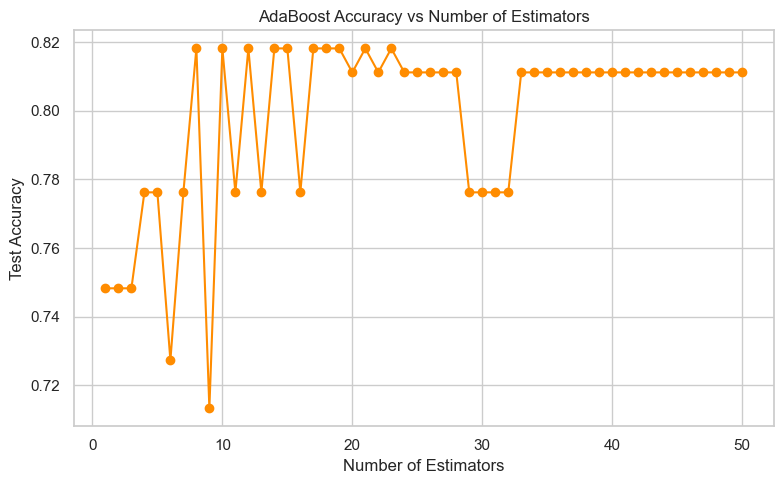

Final AdaBoost accuracy: 0.8111888111888111


In [42]:
# AdaBoost Accuracy vs Estimators (staged_score)

from sklearn.ensemble import AdaBoostClassifier

# Initialize AdaBoost classifier with 50 estimators
clf = AdaBoostClassifier(n_estimators=50, random_state=42)

# Fit the model on SMOTE-balanced training data
clf.fit(X_train_smote, y_train_smote)

# Track test accuracy at each boosting stage (after each estimator is added)
# staged_score yields accuracy at stage i after i estimators
staged_accuracies = list(clf.staged_score(X_test_scaled, y_test))
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(staged_accuracies)+1), staged_accuracies, marker='o', color='darkorange')
plt.title('AdaBoost Accuracy vs Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Final AdaBoost accuracy:", staged_accuracies[-1])


In [43]:
# This plot shows how AdaBoost's test accuracy evolves over 50 boosting rounds
# using the `staged_score` method, which evaluates the model after each new estimator is added.

# Key observations:
# - The test accuracy starts relatively low (~0.75) and improves significantly by estimator 10–15.
# - There is noticeable **fluctuation** early on (especially between estimators 5 and 20), showing that
#   some added estimators hurt performance before it stabilizes.
# - Around estimator 30 and onward, the accuracy **plateaus** around ~0.8111 and remains stable.
# - This behavior suggests that beyond a certain point (around 30 estimators), **adding more weak learners
#   does not meaningfully improve performance**—it may just increase training time.
# - The final test accuracy is approximately **81.1%**, which is consistent with your earlier evaluations.

# Conclusion:
# This analysis helps justify choosing an optimal number of estimators (e.g., 30) instead of defaulting to 50.
# It also highlights how AdaBoost improves iteratively and when it starts to **overfit or plateau**.
